Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

**Authors:** Bibhuti Ranjan Sinha  (https://www.linkedin.com/in/bibhutiranjansinha)

### Importing Skin Cancer Data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import logging
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from glob import glob


import warnings
warnings.filterwarnings('ignore') 

In [2]:
## If you are using the data by mounting the google drive, use the following :
#from google.colab import drive
#drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

In [3]:
def set_tf_loglevel(level):
    if level >= logging.FATAL:
        os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
    if level >= logging.ERROR:
        os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
    if level >= logging.WARNING:
        os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
    else:
        os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'
    logging.getLogger('tensorflow').setLevel(level)

def visualiseHistory(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs_range = range(epochs)
    
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

def model_prediction(model,classname):
    Test_image_path = os.path.join(data_dir_test, classname, '*')
    Test_image = glob(Test_image_path)
    Test_image = load_img(Test_image[-1],target_size=(180,180,3))
    plt.imshow(Test_image)
    plt.grid(False)
    
    img = np.expand_dims(Test_image,axis=0)
    pred = model.predict(img)
    pred = np.argmax(pred)
    pred_class = class_names[pred]
    print("Actual Class "+ classname +'\n'+ "Predictive Class "+pred_class )

def compile_model(model):
    #Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
    #categorical_crossentropy: Used as a loss function for a multi-class classification model where there are two or more output labels.
    model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])
    model.summary()

In [4]:
set_tf_loglevel(logging.FATAL)

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [5]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
#data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Colab Notebooks/CNNAssignmentDataset/Train")
#data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Colab Notebooks/CNNAssignmentDataset/Test')
training_data_path = "dataset/Train"
test_data_path = "dataset/Test"
data_dir_train = pathlib.Path(training_data_path)
data_dir_test = pathlib.Path(test_data_path)

In [6]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [7]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [8]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=batch_size,
                                                               image_size=(img_height,img_width), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,
                                                            image_size=(img_height,img_width), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [10]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Visualizing one instance of all the nine classes present in the dataset

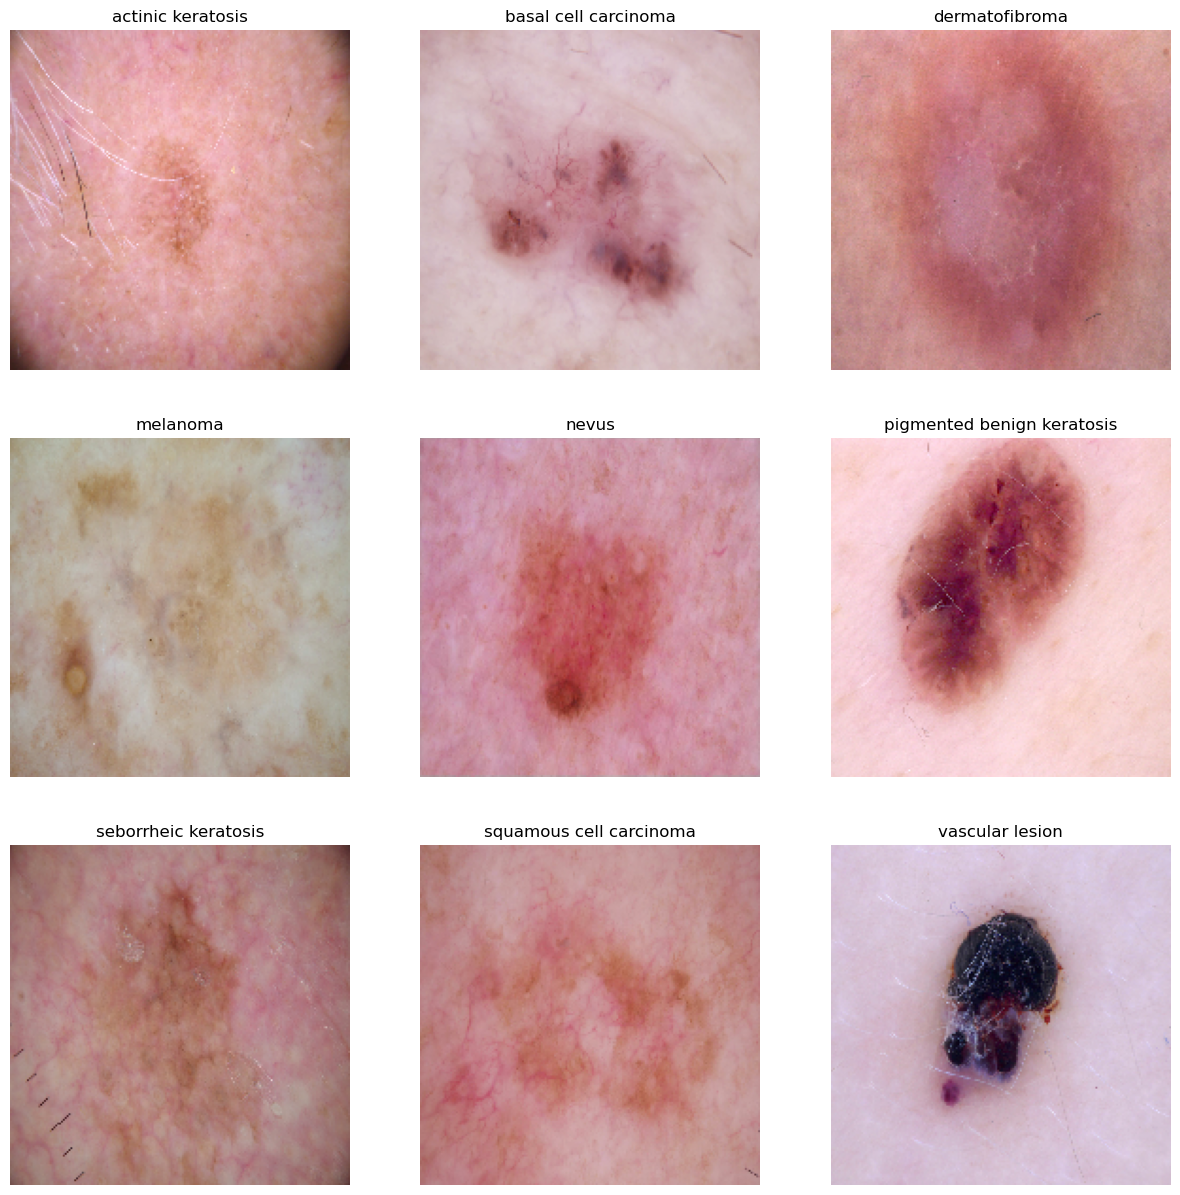

In [11]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize

#all the classes of Skin Cancer
class_names = train_ds.class_names

#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))

#Visualize image
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Creating the first model
#### Creating a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [13]:
num_classes = 9
#Sequential allows you to create models layer-by-layer  
first_model = Sequential()

#Rescaling Layer
first_model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height,img_width,3)))   

#First Convolution layer
first_model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (img_height, img_width, 32)))

#Second Convolution Layer
first_model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))

#First pool
first_model.add(MaxPool2D(pool_size=(2,2)))

#Third Convolution Layer
first_model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))

#Second pool
first_model.add(MaxPool2D(pool_size=(2,2)))

#Fourth Convolution Layer
first_model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
#Third pool
first_model.add(MaxPool2D(pool_size=(2,2)))

#Fifth Convolution Layer
first_model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))

#Fourth pool
first_model.add(MaxPool2D(pool_size=(2,2)))

## Adding dropout 
first_model.add(Dropout(0.25))

first_model.add(Flatten())
first_model.add(Dense(num_classes, activation = "softmax"))


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [14]:
compile_model(first_model)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        25632     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                   

### Train the model

In [15]:
epochs = 20
history = first_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 11s 131ms/step - loss: 2.0630 - accuracy: 0.1825 - val_loss: 2.0505 - val_accuracy: 0.1924
Epoch 2/20
56/56 [==============================] - 6s 113ms/step - loss: 2.0258 - accuracy: 0.1942 - val_loss: 2.0267 - val_accuracy: 0.1924
Epoch 3/20
56/56 [==============================] - 6s 111ms/step - loss: 1.9946 - accuracy: 0.2299 - val_loss: 2.0240 - val_accuracy: 0.2058
Epoch 4/20
56/56 [==============================] - 6s 110ms/step - loss: 2.0044 - accuracy: 0.2215 - val_loss: 2.0310 - val_accuracy: 0.2081
Epoch 5/20
56/56 [==============================] - 6s 111ms/step - loss: 1.9894 - accuracy: 0.2188 - val_loss: 2.1038 - val_accuracy: 0.1969
Epoch 6/20
56/56 [==============================] - 6s 110ms/step - loss: 1.9940 - accuracy: 0.2400 - val_loss: 2.0283 - val_accuracy: 0.2081
Epoch 7/20
56/56 [==============================] - 6s 111ms/step - loss: 1.9834 - accuracy: 0.2260 - val_loss: 2.0774 - val_accuracy: 0.1521
Epoch

### Visualizing training results

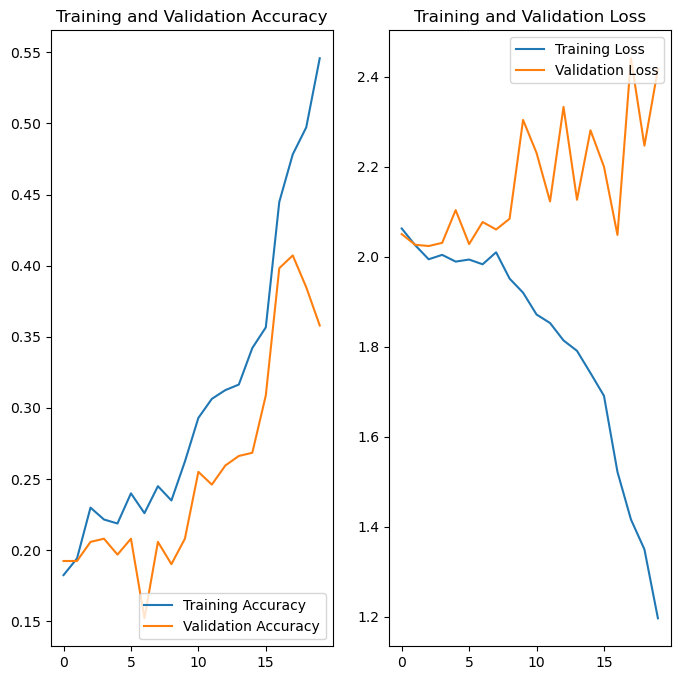

In [16]:
visualiseHistory(history)

####  Write your findings after the model fit, see if there is an evidence of model overfit or underfit

**Finding on the first base model**

- The model is overfitting because we can also see the difference in loss functions in training & testing around the 10-11th epoch

- The training and validation accuracies are very low and There is a clear sign of overfitting.


In [17]:
# As we see model is overfitting, applying a data augmentation strategy.
data_augument = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

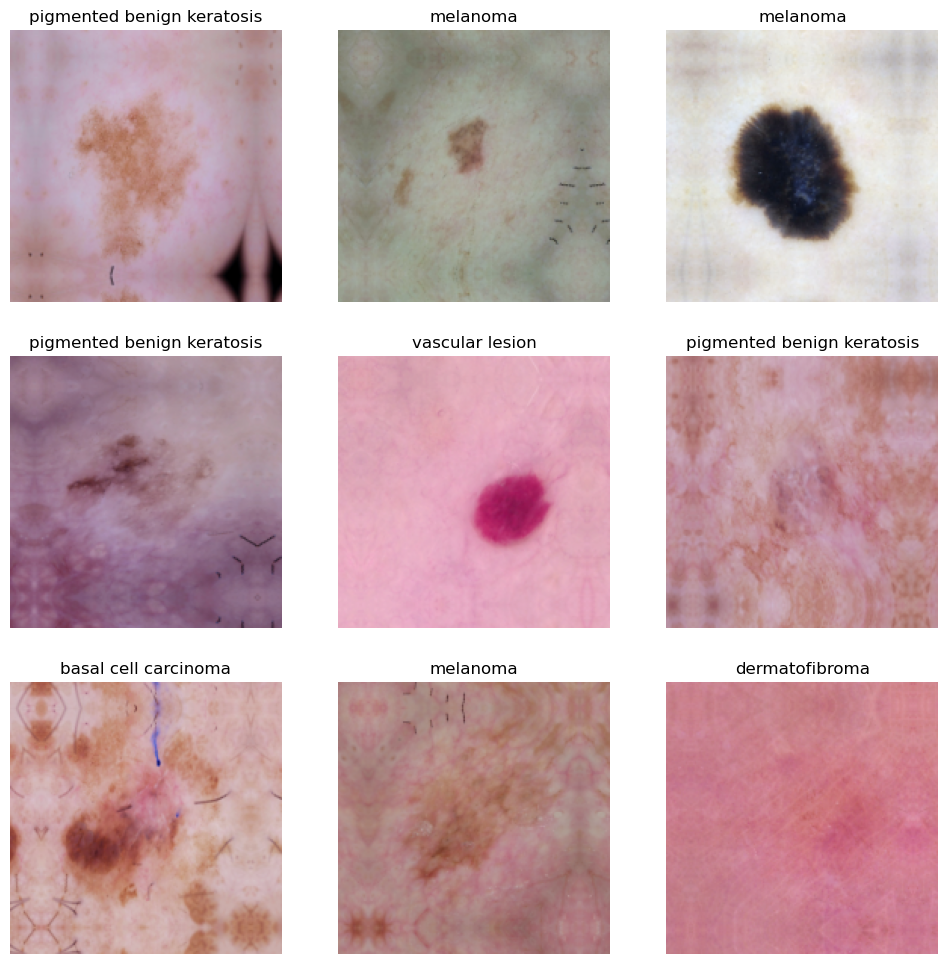

In [18]:
# visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augument(images)[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")


### Create the model, compile and train the model


In [19]:
# Creating the model and passing data_augument
#Sequential allows you to create models layer-by-layer  
second_model = Sequential([data_augument])
second_model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height,img_width,3)))   #Rescaling Layer


#First Convolution layer
second_model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))

#Second Convolution Layer
second_model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))

#First pool
second_model.add(MaxPool2D(pool_size=(2,2)))

#Third Convolution Layer
second_model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))

#Second pool
second_model.add(MaxPool2D(pool_size=(2,2)))

#Fourth Convolution Layer
second_model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
## Adding first dropout 
second_model.add(layers.Dropout(0.5))

#Fifth Convolution Layer
second_model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))

#Third pool
second_model.add(MaxPool2D(pool_size=(2,2)))

#Sixth Convolution Layer
second_model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))

#Fourth pool
second_model.add(MaxPool2D(pool_size=(2,2)))

## Adding Second dropout 
second_model.add(Dropout(0.25))

second_model.add(Flatten())
second_model.add(Dense(num_classes, activation = "softmax"))

### Compiling the model

In [20]:
compile_model(second_model)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 180, 180, 32)      2432      
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 32)      25632     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 90, 90, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        25632     
                                                      

### Training the model

In [21]:
## Your code goes here, note: train your model for 20 epochs
epochs=20
history = second_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 9s 157ms/step - loss: 2.0710 - accuracy: 0.1931 - val_loss: 2.0315 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 9s 152ms/step - loss: 2.0201 - accuracy: 0.2042 - val_loss: 2.0427 - val_accuracy: 0.2058
Epoch 3/20
56/56 [==============================] - 8s 148ms/step - loss: 2.0160 - accuracy: 0.2070 - val_loss: 2.0431 - val_accuracy: 0.1499
Epoch 4/20
56/56 [==============================] - 9s 154ms/step - loss: 2.0148 - accuracy: 0.2109 - val_loss: 2.0199 - val_accuracy: 0.2058
Epoch 5/20
56/56 [==============================] - 8s 148ms/step - loss: 1.9950 - accuracy: 0.2204 - val_loss: 2.0362 - val_accuracy: 0.2058
Epoch 6/20
56/56 [==============================] - 8s 150ms/step - loss: 1.9951 - accuracy: 0.2321 - val_loss: 2.0267 - val_accuracy: 0.2058
Epoch 7/20
56/56 [==============================] - 8s 152ms/step - loss: 1.9925 - accuracy: 0.2221 - val_loss: 2.0393 - val_accuracy: 0.2058
Epoch 

### Visualizing the results

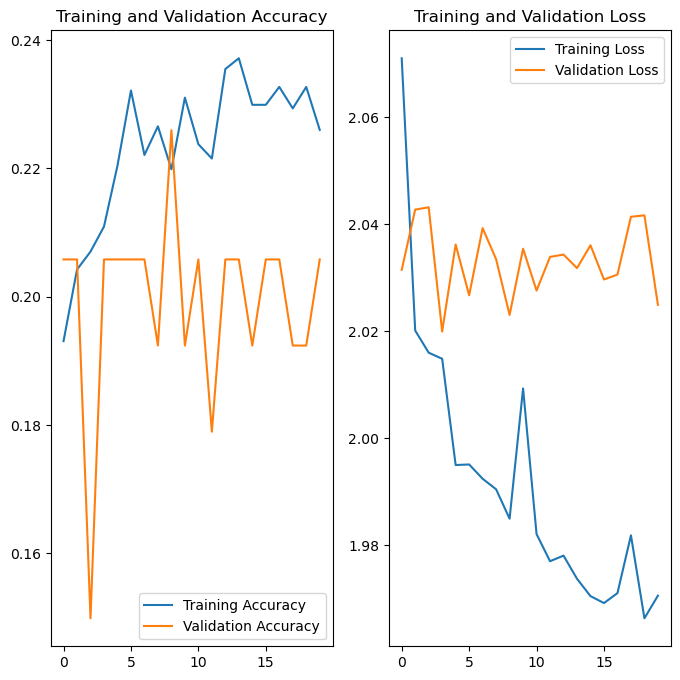

In [22]:
visualiseHistory(history)

#### Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

**Finding from Second Model**

- There is no improvement in accuracy but we can see the overfitting problem has been solved due to data augmentation

- Let's handle the class imbalance

#### Distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [23]:
path_list=[]
lesion_list=[]
for i in class_names:
    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

Path              Label
0     dataset/Train/actinic keratosis/ISIC_0029460.jpg  actinic keratosis
1     dataset/Train/actinic keratosis/ISIC_0031993.jpg  actinic keratosis
2     dataset/Train/actinic keratosis/ISIC_0029500.jpg  actinic keratosis
3     dataset/Train/actinic keratosis/ISIC_0026626.jpg  actinic keratosis
4     dataset/Train/actinic keratosis/ISIC_0032135.jpg  actinic keratosis
...                                                ...                ...
2234    dataset/Train/vascular lesion/ISIC_0032919.jpg    vascular lesion
2235    dataset/Train/vascular lesion/ISIC_0033031.jpg    vascular lesion
2236    dataset/Train/vascular lesion/ISIC_0031197.jpg    vascular lesion
2237    dataset/Train/vascular lesion/ISIC_0030882.jpg    vascular lesion
2238    dataset/Train/vascular lesion/ISIC_0029486.jpg    vascular lesion

[2239 rows x 2 columns]

In [24]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

Path              Label
0     dataset/Train/actinic keratosis/ISIC_0029460.jpg  actinic keratosis
1     dataset/Train/actinic keratosis/ISIC_0031993.jpg  actinic keratosis
2     dataset/Train/actinic keratosis/ISIC_0029500.jpg  actinic keratosis
3     dataset/Train/actinic keratosis/ISIC_0026626.jpg  actinic keratosis
4     dataset/Train/actinic keratosis/ISIC_0032135.jpg  actinic keratosis
...                                                ...                ...
2234    dataset/Train/vascular lesion/ISIC_0032919.jpg    vascular lesion
2235    dataset/Train/vascular lesion/ISIC_0033031.jpg    vascular lesion
2236    dataset/Train/vascular lesion/ISIC_0031197.jpg    vascular lesion
2237    dataset/Train/vascular lesion/ISIC_0030882.jpg    vascular lesion
2238    dataset/Train/vascular lesion/ISIC_0029486.jpg    vascular lesion

[2239 rows x 2 columns]

<BarContainer object of 9 artists>

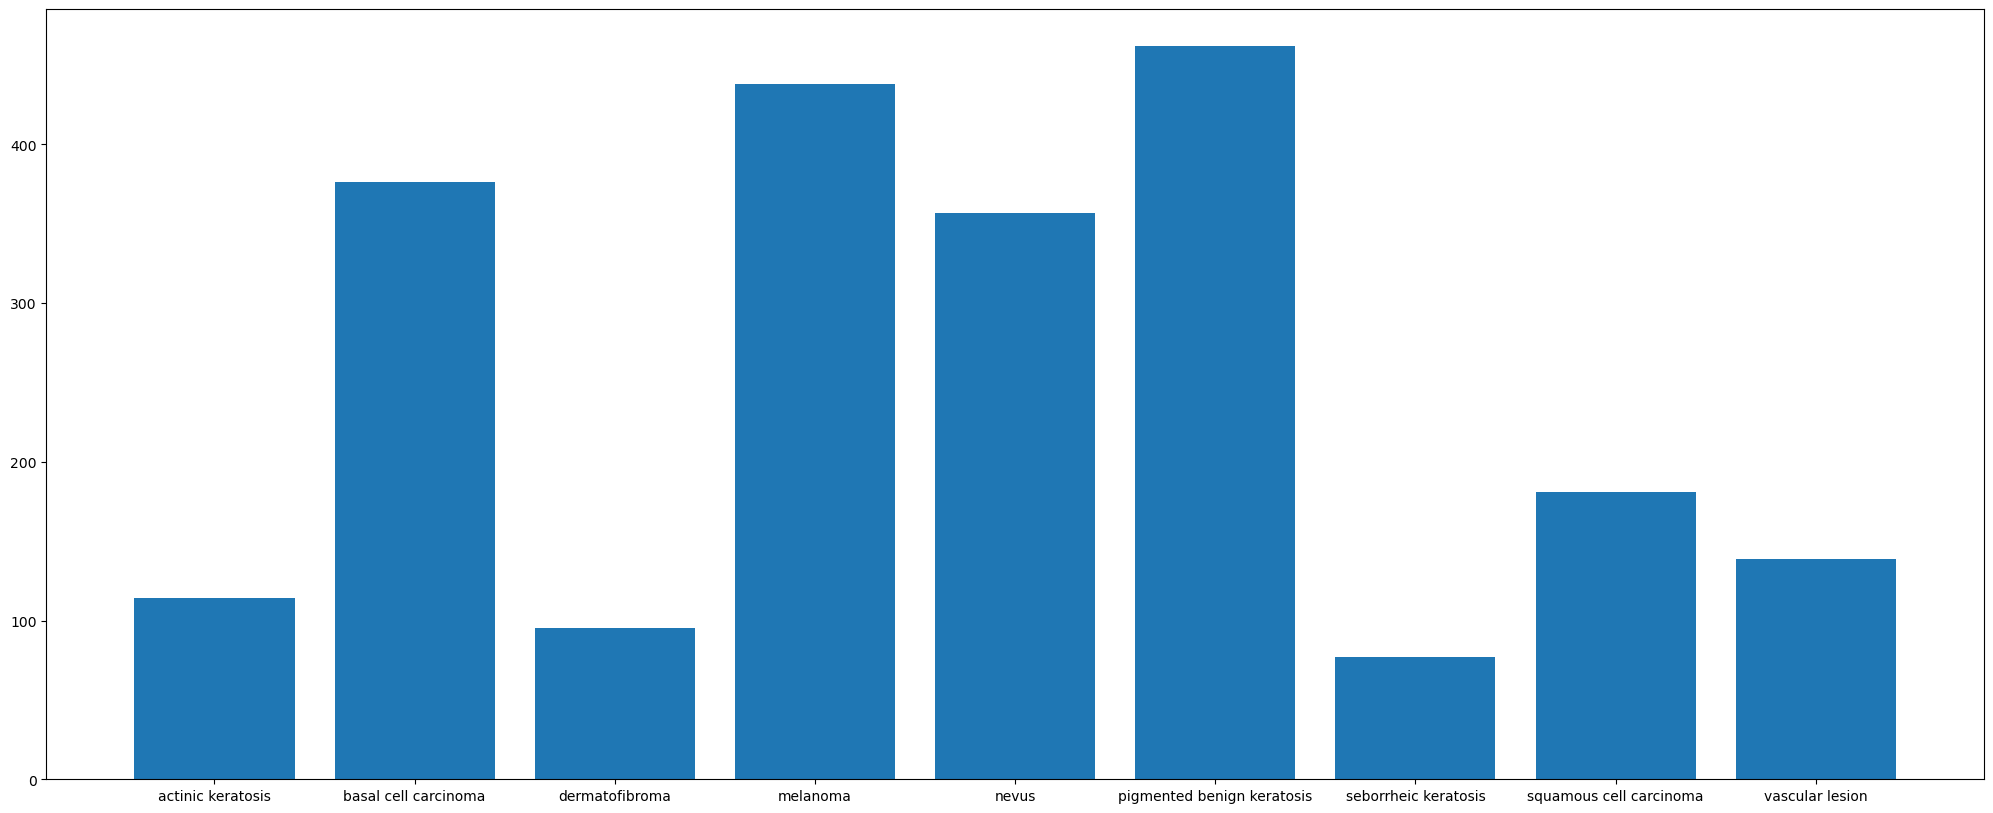

In [25]:
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


Answer-1 :- **squamous cell carcinoma** has least number of samples

Answer-2:- **actinic keratosis and dermatofibroma** have proportionate number of classes.
**melanoma and pigmented benign keratosis** have proprtionate number of classes

In [26]:
original_df['Label'].value_counts()

Label
pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: count, dtype: int64

#### Rectifying the class imbalance
#### **Context:** You can use a Python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [27]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [28]:
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(training_data_path+"/" + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to dataset/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2866EA810>: 100%|█|


Initialised with 376 image(s) found.
Output directory set to dataset/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x28685F750>: 100%|█|


Initialised with 95 image(s) found.
Output directory set to dataset/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x2


Initialised with 438 image(s) found.
Output directory set to dataset/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1936x1936 at 0x291592BD0>: 100%|


Initialised with 357 image(s) found.
Output directory set to dataset/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x293ADD290>: 100%|


Initialised with 462 image(s) found.
Output directory set to dataset/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2915926D0>: 100%|█|


Initialised with 77 image(s) found.
Output directory set to dataset/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x2867B3910>: 100%|█


Initialised with 181 image(s) found.
Output directory set to dataset/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2866EA810>: 100%|█|


Initialised with 139 image(s) found.
Output directory set to dataset/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x2


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [29]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [30]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['dataset/Train/melanoma/output/melanoma_original_ISIC_0000518.jpg_75e24d3f-3055-446b-b138-b037095debaf.jpg',
 'dataset/Train/melanoma/output/melanoma_original_ISIC_0010979.jpg_d24c6106-2f3d-4559-8252-f8f7ac116824.jpg',
 'dataset/Train/melanoma/output/melanoma_original_ISIC_0011132.jpg_f15bb9da-b850-4604-ad83-a6f1ba65af57.jpg',
 'dataset/Train/melanoma/output/melanoma_original_ISIC_0000400.jpg_fff9cc33-93ce-46d5-adc7-444b6d76e391.jpg',
 'dataset/Train/melanoma/output/melanoma_original_ISIC_0010470.jpg_b6a3698a-406c-46a8-886f-3bea28c42574.jpg',
 'dataset/Train/melanoma/output/melanoma_original_ISIC_0009916.jpg_86a74b72-1328-4357-a932-c93b53b943f7.jpg',
 'dataset/Train/melanoma/output/melanoma_original_ISIC_0010719.jpg_2fe91c27-5fcb-45ea-a315-40e0b8b1c6d6.jpg',
 'dataset/Train/melanoma/output/melanoma_original_ISIC_0000163.jpg_ef1748cd-26ee-402c-9674-87607cd35b80.jpg',
 'dataset/Train/melanoma/output/melanoma_original_ISIC_0001152.jpg_76a3d293-6396-43e5-b6a5-4c84e96ba35d.jpg',
 'dataset/

In [31]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [32]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [33]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = pd.concat([original_df,df2])

In [34]:
new_df['Label'].value_counts()

Label
pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

In [35]:
new_df

Path              Label
0      dataset/Train/actinic keratosis/ISIC_0029460.jpg  actinic keratosis
1      dataset/Train/actinic keratosis/ISIC_0031993.jpg  actinic keratosis
2      dataset/Train/actinic keratosis/ISIC_0029500.jpg  actinic keratosis
3      dataset/Train/actinic keratosis/ISIC_0026626.jpg  actinic keratosis
4      dataset/Train/actinic keratosis/ISIC_0032135.jpg  actinic keratosis
...                                                 ...                ...
4495  dataset/Train/dermatofibroma/output/dermatofib...     dermatofibroma
4496  dataset/Train/dermatofibroma/output/dermatofib...     dermatofibroma
4497  dataset/Train/dermatofibroma/output/dermatofib...     dermatofibroma
4498  dataset/Train/dermatofibroma/output/dermatofib...     dermatofibroma
4499  dataset/Train/dermatofibroma/output/dermatofib...     dermatofibroma

[6739 rows x 2 columns]

#### Training the model on the data created using Augmentor

#### Training dataset

In [36]:
#balanced_data_dir_train=training_data_path+"/output"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  label_mode='categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Validation dataset

In [37]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  label_mode='categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Create final model

In [38]:
#Sequential allows you to create models layer-by-layer  
final_model = Sequential()
final_model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height,img_width,3)))   #Rescaling Layer

#First Convolution layer
final_model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))

#Second Convolution Layer
final_model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))

#First pool
final_model.add(MaxPool2D(pool_size=(2,2)))

#Third Convolution Layer
final_model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))

#Second pool
final_model.add(MaxPool2D(pool_size=(2,2)))

#Fourth Convolution Layer
final_model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
## Adding first dropout 
final_model.add(layers.Dropout(0.5))

#Fifth Convolution Layer
final_model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))

#Third pool
final_model.add(MaxPool2D(pool_size=(2,2)))

#Sixth Convolution Layer
final_model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))

#Fourth pool
final_model.add(MaxPool2D(pool_size=(2,2)))

## Adding Second dropout 
final_model.add(Dropout(0.25))

final_model.add(Flatten())
final_model.add(Dense(num_classes, activation = "softmax"))


#### Compiling final model

In [39]:
compile_model(final_model)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 180, 180, 32)      2432      
                                                                 
 conv2d_12 (Conv2D)          (None, 180, 180, 32)      25632     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 90, 90, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 90, 90, 32)        25632     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

#### Train your model

In [40]:
epochs =30
history = final_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 25s 142ms/step - loss: 2.1879 - accuracy: 0.1404 - val_loss: 2.1880 - val_accuracy: 0.1232
Epoch 2/30
169/169 [==============================] - 24s 137ms/step - loss: 2.1125 - accuracy: 0.1847 - val_loss: 1.9710 - val_accuracy: 0.2376
Epoch 3/30
169/169 [==============================] - 24s 140ms/step - loss: 1.8465 - accuracy: 0.2773 - val_loss: 1.7565 - val_accuracy: 0.3014
Epoch 4/30
169/169 [==============================] - 23s 133ms/step - loss: 1.7187 - accuracy: 0.3466 - val_loss: 1.6124 - val_accuracy: 0.3912
Epoch 5/30
169/169 [==============================] - 23s 134ms/step - loss: 1.5689 - accuracy: 0.4019 - val_loss: 1.5479 - val_accuracy: 0.4001
Epoch 6/30
169/169 [==============================] - 23s 133ms/step - loss: 1.4779 - accuracy: 0.4364 - val_loss: 1.4862 - val_accuracy: 0.4254
Epoch 7/30
169/169 [==============================] - 22s 130ms/step - loss: 1.4210 - accuracy: 0.4629 - val_loss: 1.4008 - val_ac

####  Visualize the model results

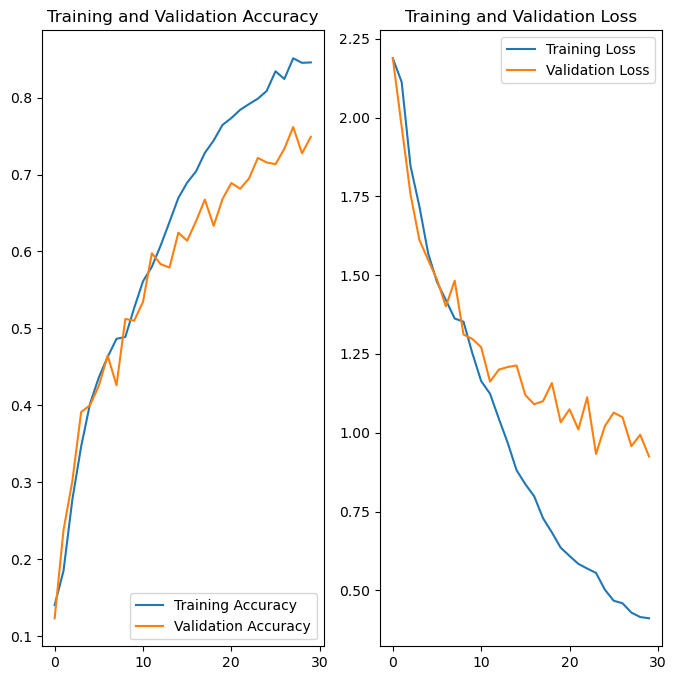

In [41]:
visualiseHistory(history)

####  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



- Accuracy increased after using using Augmentor library

- The model is still overfitting but comparably less

- The model performance can be further improved by adding more layers, neurons or dropout layers.

- The model can be also further improved by tuning the hyperparameter

### Model Prediction

1/1 [==============================] - 0s 114ms/step
Actual Class basal cell carcinoma
Predictive Class actinic keratosis


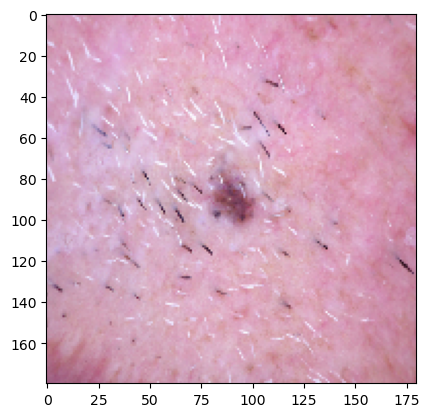

In [42]:
model_prediction(final_model,class_names[1])

1/1 [==============================] - 0s 11ms/step
Actual Class melanoma
Predictive Class nevus


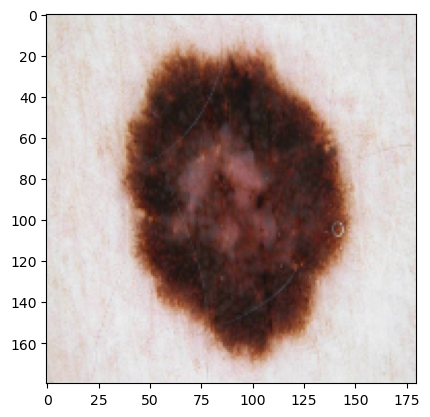

In [43]:
model_prediction(final_model,class_names[3])

1/1 [==============================] - 0s 12ms/step
Actual Class nevus
Predictive Class nevus


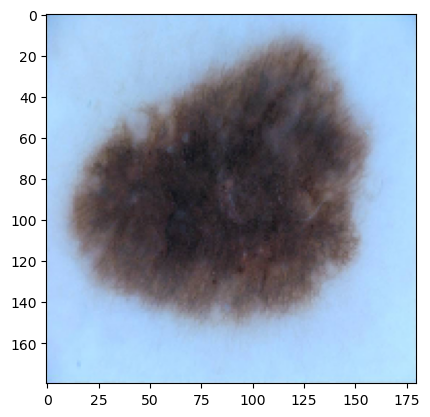

In [44]:
model_prediction(final_model,class_names[4])

1/1 [==============================] - 0s 11ms/step
Actual Class vascular lesion
Predictive Class vascular lesion


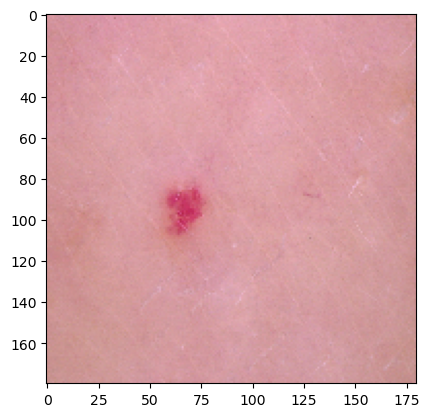

In [45]:
model_prediction(final_model,class_names[8])

####  We can see that out of 4 trials 3 prediction was correct and one was wrong

